In [1]:
!pwd
import sys
sys.executable

/c/Users/shingo/jupyter_notebook/tfgpu_py36_work/02_keras_py/experiment/01_code_test


'C:\\Users\\shingo\\Anaconda3\\envs\\tfgpu20\\python.exe'

## tf_get_train_valid.pyテスト

In [2]:
# モジュールimport
import os, sys
sys.path.append(r'C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py')
from dataset import plot_log, prepare_data, util, util, set_split
from transformer import tf_get_train_valid_test as get_train_valid_test 
from transformer import tf_my_generator as my_generator
from transformer import ndimage
from model import tf_define_model as tf_define_model
from model import tf_multi_loss as multi_loss
from model import tf_my_callback as my_callback 
from model import my_class_weight 
from predicter import roc_curve, conf_matrix, ensemble_predict
from predicter import tf_base_predict as base_predict
from predicter import tf_grad_cam as grad_cam
from predicter import tf_visualize_keras_predict as visualize_keras_predict

import tensorflow as tf
from tensorflow import keras
from keras_preprocessing import image

import glob, time
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import pathlib

%matplotlib inline
%reload_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))# 75%

output_dir = r'output_test/331x331'
os.makedirs(output_dir, exist_ok=True)

set_split.py: loaded as module file


### LabeledDatasetクラスのcreate_my_generator_flow_from_dataframe()

In [3]:
import glob
import pathlib

data_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\train\Cat'
img_paths = glob.glob(data_dir+'/*jpg')
img_names = list(map(lambda p: pathlib.Path(p).name, img_paths))
train_df = pd.DataFrame({'x_paths':img_names, 'y_ids':'0'})
train_df.head()

,x_paths,y_ids
0,10042.jpg,0
1,10053.jpg,0
2,10187.jpg,0
3,10205.jpg,0
4,10214.jpg,0


In [4]:
batch_size = 6
img_rows, img_cols, channels = 331, 331, 3

d_cls = get_train_valid_test.LabeledDataset([img_rows, img_cols, channels]
                                            , batch_size
                                            , valid_batch_size=batch_size
                                            , train_samples=train_df.shape[0]
                                            , valid_samples=train_df.shape[0]
                                           )

### 訓練画像水増しオプション
# ImageDataGenerator
rescale=1.0/255.0
# custom param
mix_up_alpha=0.2# mixup alpha
random_erasing_prob = 0.5 # random_erasing 確率
random_erasing_maxpixel = 255
ricap_beta=0.3 # RICAP beta
ricap_use_same_random_value_on_batch=True # Trueとすれば論文と同じように「ミニバッチ間で共通の乱数を使う例」。Falseにすれば、「サンプル間で別々の乱数を使う例」
is_base_aug=True # 下山さんが使っていたAutoAugmentのデフォルト？変換入れるか

# MyImageDataGenerator のオプションを辞書型で詰める
my_IDG_options={'rescale': rescale
                 , 'horizontal_flip': True
                 , 'vertical_flip': True
                 #, 'zoom_range': [1.0, 1.2]
                 #, 'rotation_range': 20
                 #, 'shear_range': 0.4
                 , 'channel_shift_range': 20.0
                 , 'brightness_range': [0.6, 1.2]
                 #, 'random_crop': random_crop
                 , 'mix_up_alpha': mix_up_alpha
                 , 'random_erasing_prob': random_erasing_prob
                 , 'random_erasing_maxpixel': random_erasing_maxpixel
                 , 'ricap_beta': ricap_beta
                 , 'ricap_use_same_random_value_on_batch': ricap_use_same_random_value_on_batch
                 #, 'is_base_aug': is_base_aug
               }

d_cls.create_my_generator_flow_from_dataframe('x_paths'
                                              , 'y_ids'
                                              , train_df
                                              , data_dir
                                              , valid_df=train_df
                                              , valid_data_dir=data_dir
                                              , color_mode='rgb'
                                              , class_mode='categorical'
                                              , my_IDG_options=my_IDG_options)
#print('len(d_cls.train_gen):', len(d_cls.train_gen)) # エラーになる
#print('len(d_cls.valid_gen):', len(d_cls.valid_gen)) # エラーになる

class_name = train_df['y_ids'].unique()
print('class_name:', type(class_name), class_name)

train_steps_per_epoch : 83
valid_steps_per_epoch : 83
my_IDG_options: {'rescale': 0.00392156862745098, 'horizontal_flip': True, 'vertical_flip': True, 'channel_shift_range': 20.0, 'brightness_range': [0.6, 1.2], 'mix_up_alpha': 0.2, 'random_erasing_prob': 0.5, 'random_erasing_maxpixel': 255, 'ricap_beta': 0.3, 'ricap_use_same_random_value_on_batch': True}
Found 500 validated image filenames belonging to 1 classes.
class_name: <class 'numpy.ndarray'> ['0']


In [5]:
dir(d_cls.train_gen)

['__class__',
 '__del__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__name__',
 '__ne__',
 '__new__',
 '__next__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'close',
 'gi_code',
 'gi_frame',
 'gi_running',
 'gi_yieldfrom',
 'send',
 'throw']

Found 500 validated image filenames belonging to 1 classes.


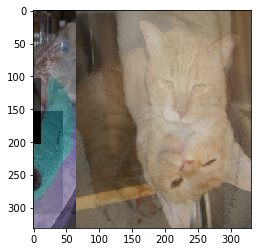

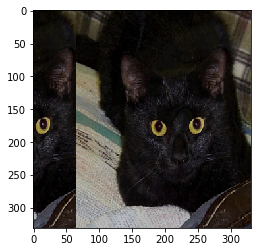

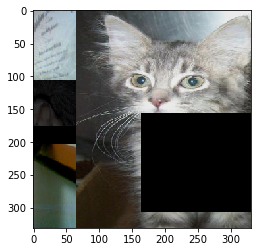

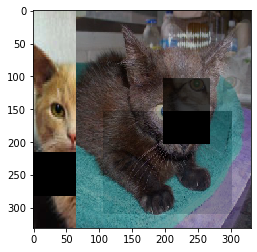

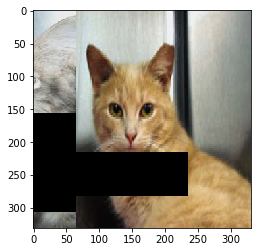

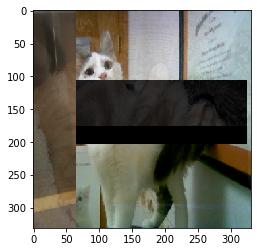

In [6]:
def print_gen(gen, i=0):
    x,y = next(gen)
    for ii in range(len(y)):
        plt.imshow(x[ii])
        plt.show()

print_gen(d_cls.train_gen, i=10)

### LabeledDatasetクラスのcreate_my_generator_flow_from_directory()

In [7]:
import glob
import pathlib

data_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\train'
img_paths = glob.glob(data_dir+'/*/*jpg')
print(len(img_paths))

1000


In [8]:
batch_size = 6
img_rows, img_cols, channels = 331, 331, 3

d_cls = get_train_valid_test.LabeledDataset([img_rows, img_cols, channels]
                                            , batch_size
                                            , valid_batch_size=batch_size
                                            , train_samples=len(img_paths)
                                            , valid_samples=len(img_paths)
                                           )

### 訓練画像水増しオプション
# ImageDataGenerator
rescale=1.0/255.0
# custom param
mix_up_alpha=0.2# mixup alpha
random_erasing_prob = 0.5 # random_erasing 確率
random_erasing_maxpixel = 255
ricap_beta=0.3 # RICAP beta
ricap_use_same_random_value_on_batch=True # Trueとすれば論文と同じように「ミニバッチ間で共通の乱数を使う例」。Falseにすれば、「サンプル間で別々の乱数を使う例」
is_base_aug=True # 下山さんが使っていたAutoAugmentのデフォルト？変換入れるか

# MyImageDataGenerator のオプションを辞書型で詰める
my_IDG_options={'rescale': rescale
                 , 'horizontal_flip': True
                 , 'vertical_flip': True
                 #, 'zoom_range': [1.0, 1.2]
                 #, 'rotation_range': 20
                 #, 'shear_range': 0.4
                 , 'channel_shift_range': 20.0
                 , 'brightness_range': [0.6, 1.2]
                 #, 'random_crop': random_crop
                 , 'mix_up_alpha': mix_up_alpha
                 , 'random_erasing_prob': random_erasing_prob
                 , 'random_erasing_maxpixel': random_erasing_maxpixel
                 , 'ricap_beta': ricap_beta
                 , 'ricap_use_same_random_value_on_batch': ricap_use_same_random_value_on_batch
                 #, 'is_base_aug': is_base_aug
               }

d_cls.create_my_generator_flow_from_directory(data_dir, ['Cat', 'Dog']
                                              , color_mode='rgb'
                                              , class_mode='categorical'
                                              , my_IDG_options=my_IDG_options)
#print('len(d_cls.train_gen):', len(d_cls.train_gen)) # エラーになる
#print('len(d_cls.valid_gen):', len(d_cls.valid_gen)) # エラーになる

train_steps_per_epoch : 166
valid_steps_per_epoch : 166
my_IDG_options: {'rescale': 0.00392156862745098, 'horizontal_flip': True, 'vertical_flip': True, 'channel_shift_range': 20.0, 'brightness_range': [0.6, 1.2], 'mix_up_alpha': 0.2, 'random_erasing_prob': 0.5, 'random_erasing_maxpixel': 255, 'ricap_beta': 0.3, 'ricap_use_same_random_value_on_batch': True}


(<generator object MyImageDataGenerator.flow_from_directory at 0x000002068100EDC8>,
 None,
 None)

x.shape: (6, 331, 331, 3)
x[0]:
 [[[0.50065442 0.52831082 0.49560185]
  [0.52888323 0.5673349  0.53446436]
  [0.52888323 0.56749647 0.53478751]
  ...
  [0.26266816 0.2156414  0.13334937]
  [0.26268098 0.21565423 0.13336701]
  [0.27444088 0.21565102 0.12944704]]

 [[0.53324567 0.57315148 0.54060409]
  [0.53911991 0.58246258 0.56119518]
  [0.55850852 0.60265905 0.58123007]
  ...
  [0.26270663 0.21568148 0.13339106]
  [0.26269541 0.21566705 0.13337823]
  [0.27446172 0.21567347 0.12946949]]

 [[0.52149478 0.56451431 0.53293634]
  [0.52240654 0.57294607 0.55608494]
  [0.53433282 0.59287705 0.57585436]
  ...
  [0.26272587 0.21569912 0.13340869]
  [0.26270343 0.21567828 0.13338625]
  [0.27447455 0.21568308 0.1294775 ]]

 ...

 [[0.03759997 0.04511997 0.03383997]
  [0.04135997 0.04887996 0.03759997]
  [0.04135997 0.04887996 0.02631998]
  ...
  [0.1217576  0.09811103 0.08231137]
  [0.12202594 0.09834913 0.082489  ]
  [0.12622718 0.10257305 0.09059669]]

 [[0.03383997 0.04135997 0.02631998]
  [0

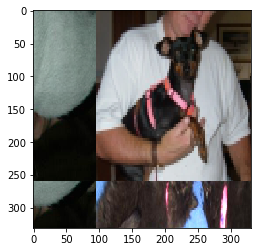

y[1]: [0.78247734 0.21752266]


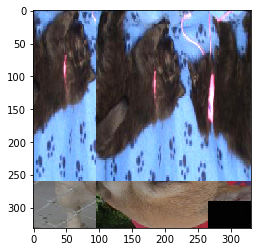

y[2]: [0.02158397 0.97841603]


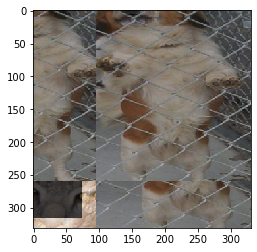

y[3]: [6.31367679e-05 9.99936863e-01]


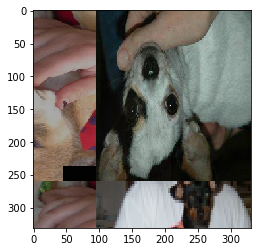

y[4]: [0.2532429 0.7467571]


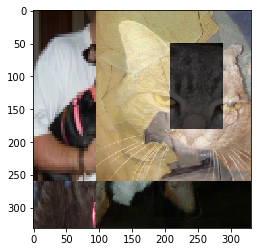

y[5]: [0.13050389 0.86949611]


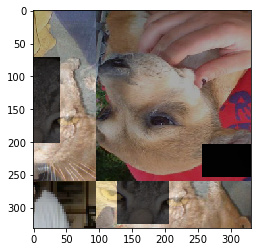

In [13]:
my_generator.print_image_generator(d_cls.train_gen, i=0)

### tf_get_train_valid_test.pyの不均衡データ補正系の関数

In [43]:
data_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\train\Cat'
img_paths = glob.glob(data_dir+'/*jpg')
img_names = list(map(lambda p: pathlib.Path(p).name, img_paths))
train_df = pd.DataFrame({'x_paths':img_names, 'y_ids':'0'})
#display(train_df.head())
#print(train_df.shape)

# ランダムにラベル=1のレコード100件作る
train_df.ix[np.random.randint(1,500,100),'y_ids'] = '1'
display(train_df.head())
print(train_df.shape)

,x_paths,y_ids
0,10042.jpg,0
1,10053.jpg,0
2,10187.jpg,0
3,10205.jpg,0
4,10214.jpg,0


(500, 2)


In [48]:
batch_size = 6
img_rows, img_cols, channels = 331, 331, 3

d_cls = get_train_valid_test.LabeledDataset([img_rows, img_cols, channels]
                                            , batch_size
                                            , valid_batch_size=batch_size
                                            , train_samples=train_df.shape[0]
                                            , valid_samples=train_df.shape[0]
                                           )
my_IDG_options={'rescale': 1.0/255.0}
d_cls.create_my_generator_flow_from_dataframe('x_paths'
                                              , 'y_ids'
                                              , train_df
                                              , data_dir
                                              , valid_df=train_df
                                              , valid_data_dir=data_dir
                                              , color_mode='rgb'
                                              , class_mode='categorical'
                                              , my_IDG_options=my_IDG_options)

class_name = train_df['y_ids'].unique()
print('class_name:', type(class_name), class_name)

X, y = next(d_cls.train_gen)
print(X.shape, y.shape)
print(y)

train_steps_per_epoch : 83
valid_steps_per_epoch : 83
my_IDG_options: {'rescale': 0.00392156862745098}
Found 500 validated image filenames belonging to 2 classes.
class_name: <class 'numpy.ndarray'> ['0' '1']
Found 500 validated image filenames belonging to 2 classes.
(6, 331, 331, 3) (6, 2)
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


### 分布確認

In [49]:
X, y = next(d_cls.train_gen)
print(X.shape, y.shape)
print(y)

dict_num_y = get_train_valid_test. get_class_distribution(y)
print(dict_num_y)

list_num_y = get_train_valid_test.get_class_distribution_list(y, 2)
print(list_num_y)

(6, 331, 331, 3) (6, 2)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
{0: 6}
[6. 0.]


###  over_sampling

In [52]:
X, y = next(d_cls.train_gen)
print(X.shape, y.shape)
print(y)

X, y = get_train_valid_test.balance_class_by_over_sampling(X, y)
print(X.shape, y.shape)
print(y)

(6, 331, 331, 3) (6, 2)
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]
{0: 3, 1: 3}
(6, 331, 331, 3) (6, 2)
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


(6, 331, 331, 3) (6, 2)
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
{0: 5, 1: 5}
X.shape y.shape: (6,) (6,)
y_resampled.value_counts():
1    5
0    5
dtype: int64


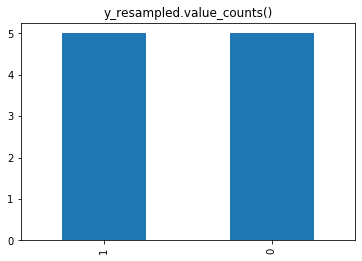

X_resampled.shape y_resampled.shape: (1, 331, 3) (10,)
(1, 331, 3) (10,)
[1 0 0 0 0 0 1 1 1 1]


In [62]:
X, y = next(d_cls.train_gen)
print(X.shape, y.shape)
print(y)

y = np.array([np.argmax(y) for y in y])
dict_class_counts = get_train_valid_test.get_dict_class_counts(y, is_maximize_all_class=True)
print(dict_class_counts)
X, y = get_train_valid_test.imblearn_under_over_sampling(X, y, dict_class_counts)
print(X.shape, y.shape)
print(y)